In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from pathlib import Path
from tqdm import tqdm
import os

TODO:
- Table with metrics summary (mean + std)
- Create full plot (with multiple subplots)
- Possibly: assert to check ass exp uses same dsets

In [2]:
# Make sure the path is correct, i.e. change according which experiment we want
# root_path = Path('results_atari')
root_path = Path('results')

experiments = sorted([path.stem for path in root_path.iterdir()])
exp_box = [widgets.Checkbox(value=False, description=label, layout=widgets.Layout(width='600px')) for label in experiments]
exp_vbox = widgets.VBox(exp_box)
display(exp_vbox)

In [3]:
OUTPUT_FOLDER = root_path / 'deleteme'
assert not os.path.exists(OUTPUT_FOLDER)
os.mkdir(OUTPUT_FOLDER), 'OUTPUT FOLDER ALREADY EXISTS! Delete it or change name'

(None, 'OUTPUT FOLDER ALREADY EXISTS! Delete it or change name')

In [10]:
# Load data
metrics_paths = []
for checkbox in exp_box:
    if checkbox.value == True:
        metrics_paths.append((checkbox.description, root_path / checkbox.description / 'run_plot' / 'metrics.csv'))

# Get only exp names
exps_names = [n for n, _ in metrics_paths]

# load dfs and put in a dict with exp name as key
dfs = {name: pd.read_csv(mpath) for name, mpath in metrics_paths}

In [11]:
metrics_plot = dfs[exps_names[0]]
datasets_checkboxes = [widgets.Checkbox(value=True, description=label) for label in pd.unique(metrics_plot['dataset'])]
datasets_vbox = widgets.VBox(children=datasets_checkboxes)
 
metrics_checkboxes = [widgets.Checkbox(value=True, description=label) for label in pd.unique(metrics_plot['metric'])]
metrics_vbox = widgets.VBox(children=metrics_checkboxes)

split_checkboxes = [widgets.Checkbox(value=True, description=label) for label in ['train', 'validation', 'test']]
split_vbox = widgets.VBox(split_checkboxes)


vboxes = [datasets_vbox, metrics_vbox, split_vbox]
output = widgets.HBox(children=vboxes)
display(output)

In [12]:
# Get selected dsets
dsets = [d.description for d in datasets_checkboxes if d.value == True]
# Get selected metrics
metrics = [m.description for m in metrics_checkboxes if m.value == True]
# Get selected splits (train, validation, test)
splits = [c.description for c in split_checkboxes if c.value == True]


# TODO: loop
dset_name = 'BUS_SELECTED'
metric_name = 'f1score'


values = pd.DataFrame()
vs = []
# Loop over dsets
for dset_name in dsets:
    # Loop over metrics
    for metric_name in metrics:
        # Loop over type (train, validation, test)
        for split in splits:
            # Loop over dset
            for exp in exps_names:
                # Get dataframe
                df = dfs[exp]
                # Filted dset
                df = df[df['dataset'] == dset_name]
                # Filter metrics
                df = df[df['metric'] == metric_name]
                # Select split
                df_split = df[df['split'] == split]
                # Remove -1, only for test split actually
                df_split = df_split[df_split['epoch'] != -1]
                # Create column name
                col_name = f"{exp}_{dset_name}_{metric_name}_{split}"
                # Insert in df with new index
                vs.append(df_split['value'].set_axis(df_split['epoch'], axis=0).rename(col_name))
#                 values.insert(0, col_name, df_split['value'].set_axis(df_split['epoch'])) # works also
# Merge into a single df
values = pd.concat(vs, axis=1)
values

,20230513_baseline_bus_4_BUS_SELECTED_loss_train,20230513_baseline_bus_4_BUS_SELECTED_loss_validation,20230513_baseline_bus_4_BUS_SELECTED_loss_test,20230513_baseline_bus_4_BUS_SELECTED_accuracy_train,20230513_baseline_bus_4_BUS_SELECTED_accuracy_validation,20230513_baseline_bus_4_BUS_SELECTED_accuracy_test,20230513_baseline_bus_4_BUS_SELECTED_precision_train,20230513_baseline_bus_4_BUS_SELECTED_precision_validation,20230513_baseline_bus_4_BUS_SELECTED_precision_test,20230513_baseline_bus_4_BUS_SELECTED_recall_train,...,20230513_baseline_bus_4_BUS_SELECTED_specificity_test,20230513_baseline_bus_4_BUS_SELECTED_iou_train,20230513_baseline_bus_4_BUS_SELECTED_iou_validation,20230513_baseline_bus_4_BUS_SELECTED_iou_test,20230513_baseline_bus_4_BUS_SELECTED_dice_train,20230513_baseline_bus_4_BUS_SELECTED_dice_validation,20230513_baseline_bus_4_BUS_SELECTED_dice_test,20230513_baseline_bus_4_BUS_SELECTED_hd_train,20230513_baseline_bus_4_BUS_SELECTED_hd_validation,20230513_baseline_bus_4_BUS_SELECTED_hd_test
epoch,,,,,,,,,,,,,,,,,,,,,
0,0.882855,0.763274,0.761283,0.956330,0.912384,0.915021,0.000000,0.000000,0.000000,0.000000,...,0.993759,0.000000,0.000000,0.000000,6.668125e-11,2.291523e-10,2.244488e-10,444.586148,374.310855,386.599581
62,0.817405,0.761069,0.659414,0.995032,0.960716,0.977767,0.888592,0.866383,0.899026,0.993578,...,0.992168,0.883518,0.562170,0.742805,9.381570e-01,7.197294e-01,8.524249e-01,18.488803,132.418836,58.332971
124,0.828872,0.683453,0.675338,0.996709,0.961864,0.981152,0.925644,0.867743,0.935646,0.992985,...,0.995156,0.919631,0.575434,0.774789,9.581328e-01,7.305088e-01,8.731056e-01,30.919514,113.923931,53.052937
186,0.821700,0.707133,0.666202,0.995905,0.961728,0.978923,0.903989,0.908645,0.924442,0.998028,...,0.994378,0.902377,0.559221,0.750303,9.486839e-01,7.173081e-01,8.573409e-01,21.612909,103.769414,56.375052
248,0.818495,0.712881,0.711186,0.996718,0.965423,0.980779,0.923632,0.888347,0.920310,0.995796,...,0.993821,0.920044,0.610419,0.773665,9.583573e-01,7.580870e-01,8.723911e-01,8.984946,84.594332,72.109849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5952,0.820075,0.664691,0.673077,0.999467,0.963343,0.979892,0.986405,0.925678,0.951062,0.999724,...,0.996517,0.986137,0.573252,0.756091,9.930202e-01,7.287481e-01,8.611066e-01,1.961737,159.603382,71.959846
6014,0.810391,0.671933,0.662443,0.999750,0.964419,0.980974,0.993725,0.926619,0.954875,0.999711,...,0.996757,0.993439,0.585951,0.768595,9.967090e-01,7.389269e-01,8.691591e-01,1.443408,96.088703,56.339044
6076,0.805359,0.666634,0.691691,0.999768,0.964609,0.981541,0.994117,0.936379,0.968042,0.999803,...,0.997747,0.993922,0.585293,0.772971,9.969519e-01,7.384033e-01,8.719497e-01,1.339402,83.024371,70.371807


In [13]:
def pretty_dset_name(name):
    if name == "BUS_SELECTED":
        return "UDIAT"
    else:
        return name
    
pretty_print = {
    'auc': 'AUC',
    'loss': 'Loss',
    'accuracy': 'Accuracy',
    'precision': 'Precision',
    'recall': 'Recall',
    'f1score': 'F1 Score',
    'specificity': 'Specificity',
    'trained': 'Training',
    'specialized': 'Specialization',
    'iou': 'IoU',
    'dice': 'Dice Score',
    'hd': 'HD'
}

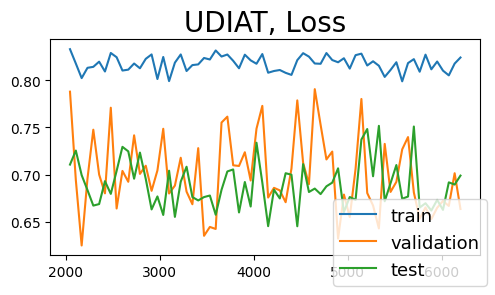

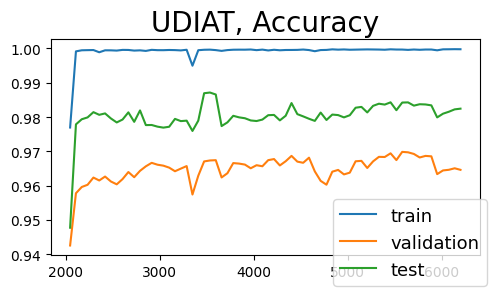

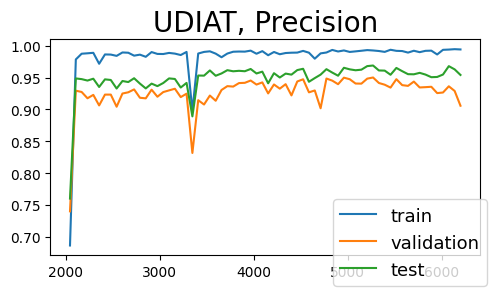

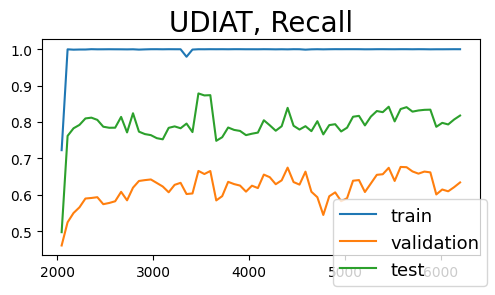

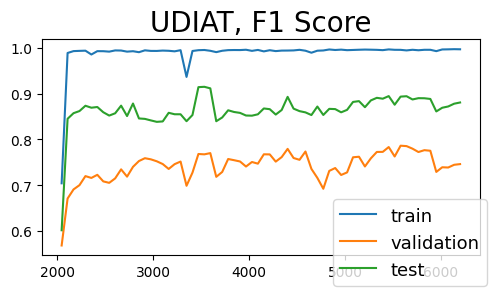

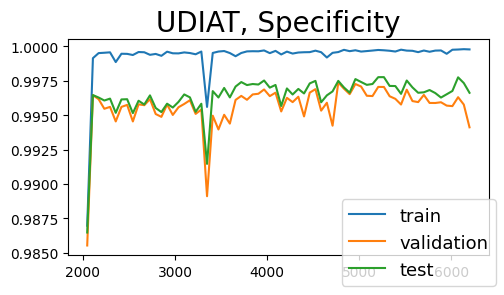

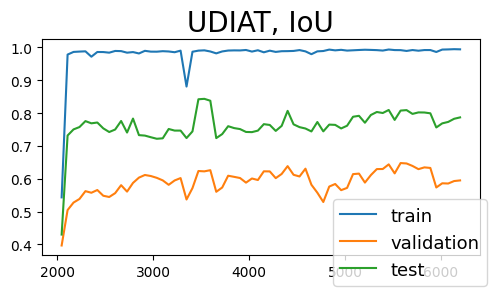

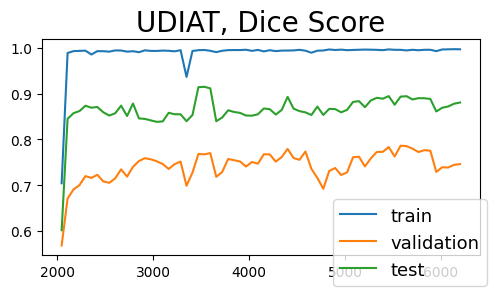

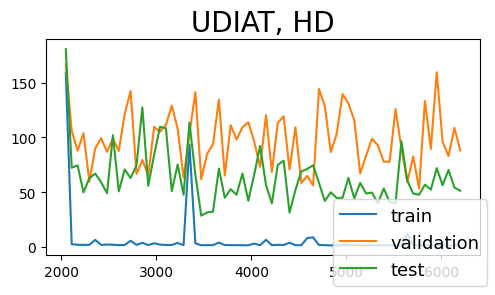

In [14]:
MIN_EPOCH = 2000
df = values.loc[MIN_EPOCH:]

for dset_name in dsets:
    for metric_name in metrics:
        # Create new image
        fig, ax = plt.subplots(figsize=(5, 3))

        for split in splits:
            cols = [f"{exp}_{dset_name}_{metric_name}_{split}" for exp in exps_names]
            x = df[cols].index
            mean_val = df[cols].mean(axis=1)
            std_val = df[cols].std(axis=1)
            ax.plot(x, mean_val, label=split)
            ax.fill_between(x, mean_val + std_val, mean_val - std_val, alpha=.25)

        title = f"{pretty_dset_name(dset_name)}_{metric_name}"
        plt.title(f"{pretty_dset_name(dset_name)}, {pretty_print[metric_name]}", size=20)
        fig.legend(loc='lower right', fontsize=13)
        fig.tight_layout()
        plt.savefig(OUTPUT_FOLDER / f"{title}.pdf")
        plt.show()

In [ ]:
df